In [1]:
import cntk as C
import os
import numpy as np
from cntk.io import (MinibatchSource, CTFDeserializer, StreamDef, StreamDefs,
                     INFINITELY_REPEAT, FULL_DATA_SWEEP)
from cntk import Trainer
from cntk.layers import Sequential, For, Dense
from cntk.learners import (adam, UnitType, learning_rate_schedule,
                          momentum_as_time_constant_schedule, momentum_schedule)
from cntk.logging import *
from cntk.logging.graph import find_by_name, get_node_outputs

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
image_height = 28
image_width = 28
num_channels = 1
num_classes = 10
d_input_dim = (num_channels, image_height, image_width)
input_dim = image_width*image_height

lr= 1e-4
mm = 0.5
mm_var = 0.999
lambda_k = 0.001
gamma = 0.5

embedding = 32
num_minibatches = 10000
minibatch_size = 64
lr_update_step = 5000

num_hidden_layers = 2
hidden_layers_dim = 64

In [3]:
def check_path(path):
    if not os.path.exists(path):
        readme_file = os.path.normpath(os.path.join(
            os.path.dirname(path), "..", "README.md"))
        raise RuntimeError(
            "File '%s' does not exist. Please follow the instructions at %s to download and prepare it." % (path, readme_file))

def create_reader(path, is_training, input_dim, label_dim):
    return MinibatchSource(CTFDeserializer(path, StreamDefs(
        features  = StreamDef(field='features', shape=input_dim, is_sparse=False),
        labels    = StreamDef(field='labels',   shape=label_dim, is_sparse=False)
    )), randomize=is_training, max_sweeps = INFINITELY_REPEAT if is_training else 1)

In [4]:
np.random.seed(123)
def noise_sample(num_samples):
    return np.random.uniform(
        low = -1.0,
        high = 1.0,
        size = [num_samples, embedding]
    ).astype(np.float32)

In [5]:
def l1_loss(a,b):
    return C.reduce_mean(C.abs(a - b), axis=C.Axis.all_axes())

def l2_loss(a,b):
#     return C.sqrt(C.reduce_sum(C.square(a - b), axis=C.Axis.all_axes())) / input_dim
    return C.sqrt(C.reduce_sum(C.square(a - b))) / input_dim

def generator(x):
    with C.default_options(activation=None):       
        x = Sequential([For(range(num_hidden_layers), lambda i: 
                            Dense(hidden_layers_dim, activation=C.elu)),
                        Dense(input_dim, activation=C.sigmoid)])(x)

    return x

def discriminator(x):
    with C.default_options(activation=None):
        x = Sequential([For(range(num_hidden_layers), lambda i: 
                            Dense(hidden_layers_dim, activation=C.elu)),
                        Dense(embedding, activation=None)])(x)

        x = Sequential([For(range(num_hidden_layers), lambda i: 
                            Dense(hidden_layers_dim, activation=C.elu)),
                        Dense(input_dim, activation=C.sigmoid)])(x)
        
    return x

In [6]:
if __name__=='__main__':
    abs_path   = os.path.dirname(os.path.abspath('./'))
    model_path = os.path.join(abs_path, "Models")
    log_dir = None
    model_name   = "BEGAN.model"
    
    data_path = os.path.join('./')

    path = os.path.normpath(os.path.join(data_path, "Train-28x28_cntk_text.txt"))
    check_path(path)

    reader_train = create_reader(path, True, input_dim, num_classes)

    ##
    noise_shape = embedding
    image_shape = d_input_dim
    input_dynamic_axes = [C.Axis.default_batch_axis()]
    Z = C.input(noise_shape, dynamic_axes=input_dynamic_axes)
    X_real = C.input(input_dim, dynamic_axes=input_dynamic_axes)
    X_real_scaled = X_real / 255
    kt_in = C.input(1, dynamic_axes=input_dynamic_axes)
    
    # Create the model function for the generator and discriminator models
    X_fake = generator(Z)
    D_real = discriminator(X_real_scaled)
    D_fake = D_real.clone(
        method = 'share',
        substitutions = {X_real_scaled.output: X_fake.output})
    
    # Create loss functions and configure optimazation algorithms
    D_real_loss = l2_loss(X_real_scaled, D_real)
    D_fake_loss = l2_loss(X_fake, D_fake)
    G_loss = D_fake_loss
    D_loss = D_real_loss - kt_in*D_fake_loss
    
    lr_schedule = list( lr * np.asarray([0.5**t for t in range(0,num_minibatches//lr_update_step+1)]) )
    G_learner = adam(
        parameters = X_fake.parameters,
        lr = learning_rate_schedule(lr_schedule, UnitType.sample, lr_update_step*minibatch_size),
        momentum = momentum_schedule(mm),
        variance_momentum = momentum_schedule(mm_var)
    )
    D_learner = adam(
        parameters = D_real.parameters,
        lr = learning_rate_schedule(lr_schedule, UnitType.sample, lr_update_step*minibatch_size),
        momentum = momentum_schedule(mm),
        variance_momentum = momentum_schedule(mm_var)
    )


    print_frequency_mbsize = 100
    pp_G = ProgressPrinter(print_frequency_mbsize)
    pp_D = ProgressPrinter(print_frequency_mbsize)
    tensorboard_logdir = 'log/'
    tb_G = TensorBoardProgressWriter(freq = print_frequency_mbsize, log_dir=tensorboard_logdir)
    tb_D = TensorBoardProgressWriter(freq = print_frequency_mbsize, log_dir=tensorboard_logdir)
    
    
    # Instantiate the trainers
    G_trainer = Trainer(
        X_fake,
        (G_loss, None),
        G_learner,
        pp_G
    )
    D_trainer = Trainer(
        D_real,
        (D_loss, None),
        D_learner,
        pp_D
    )

In [7]:
    is_retraining = False
    if is_retraining:
        G_trainer.restore_from_checkpoint('Models/BEGAN_G_{}.dnn'.format(43000))
        D_trainer.restore_from_checkpoint('Models/BEGAN_D_{}.dnn'.format(43000))
        kt = 0.01195829
    else:
        kt = 0.0
    ##
    input_map = {X_real: reader_train.streams.features}
    m_global_pre = 10
    
    X_fake_node  = C.combine([X_fake.owner])
    D_fake_node  = C.combine([D_fake.owner])
    D_real_node  = C.combine([D_real.owner])
    for train_step in range(num_minibatches):       
        Z_data = noise_sample(minibatch_size)
        batch_inputs = {Z: Z_data}
        G_trainer.train_minibatch(batch_inputs)
        
        Z_data = noise_sample(minibatch_size)
        X_data = reader_train.next_minibatch(minibatch_size, input_map)
        batch_inputs = {X_real: X_data[X_real].data, Z: Z_data,
                        kt_in: kt*np.ones((minibatch_size, 1)).astype(np.float32)}
        D_trainer.train_minibatch(batch_inputs)
        
        temp = C.combine([C.reduce_mean(D_real_loss, axis=C.Axis.all_axes()),
                       C.reduce_mean(D_fake_loss, axis=C.Axis.all_axes())]
                     ).eval({X_real: X_data[X_real].data, Z: Z_data})
        val = list(temp.values())
        kt = np.asarray(C.clip(C.constant(kt) + lambda_k*(gamma * val[0] - val[1]), 0, 1).eval())
        m_global = val[0] + np.abs(gamma * val[0] - val[1])
        tb_D.write_value("m_global", m_global, train_step)
        tb_D.write_value("kt", kt, train_step)

        if train_step % 100 == 0 and m_global < m_global_pre:
            G_trainer.save_checkpoint('Models/BEGAN_G_{}.dnn'.format(train_step))
            D_trainer.save_checkpoint('Models/BEGAN_D_{}.dnn'.format(train_step))
            m_global_pre = m_global           

Learning rate per sample: 0.0001
Learning rate per sample: 0.0001
 Minibatch[   1- 100]: loss = 0.001890 * 6400, metric = 0.00% * 6400;
 Minibatch[   1- 100]: loss = 0.016882 * 6400, metric = 0.00% * 6400;
 Minibatch[ 101- 200]: loss = 0.011378 * 6400, metric = 0.00% * 6400;
 Minibatch[ 101- 200]: loss = 0.011512 * 6400, metric = 0.00% * 6400;
 Minibatch[ 201- 300]: loss = 0.014561 * 6400, metric = 0.00% * 6400;
 Minibatch[ 201- 300]: loss = 0.009337 * 6400, metric = 0.00% * 6400;
 Minibatch[ 301- 400]: loss = 0.014161 * 6400, metric = 0.00% * 6400;
 Minibatch[ 301- 400]: loss = 0.009215 * 6400, metric = 0.00% * 6400;
 Minibatch[ 401- 500]: loss = 0.012764 * 6400, metric = 0.00% * 6400;
 Minibatch[ 401- 500]: loss = 0.009161 * 6400, metric = 0.00% * 6400;
 Minibatch[ 501- 600]: loss = 0.009423 * 6400, metric = 0.00% * 6400;
 Minibatch[ 501- 600]: loss = 0.009095 * 6400, metric = 0.00% * 6400;
 Minibatch[ 601- 700]: loss = 0.004777 * 6400, metric = 0.00% * 6400;
 Minibatch[ 601- 700]: l

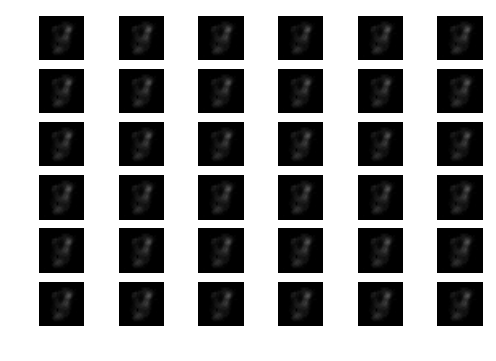

In [8]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image.reshape(28, 28), vmin=0, vmax=1.0, cmap='gray')
        ax.axis('off')
    plt.show()

X_fake_output = X_fake_node.eval({Z: noise_sample(36)})
plot_images(X_fake_output, subplot_shape=[6, 6])

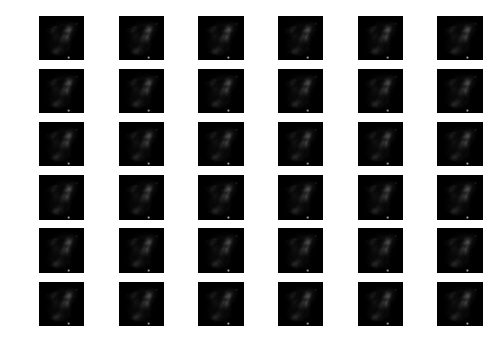

In [9]:
# Test for Discriminator (fake image)
D_real_node  = C.combine([D_real.owner])
D_real_output = D_real_node.eval({X_real: 255*X_fake_output})
plot_images(D_real_output, subplot_shape=[6, 6])

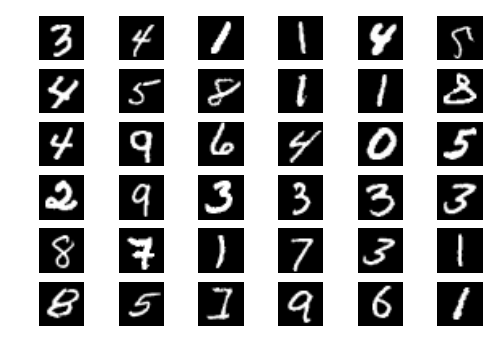

In [10]:
X_data = reader_train.next_minibatch(minibatch_size, input_map)
images = X_data[X_real].data
IMG = C.input(input_dim, dynamic_axes=input_dynamic_axes)
A = IMG/255
plot_images(A.eval({IMG: images}), subplot_shape=[6, 6])

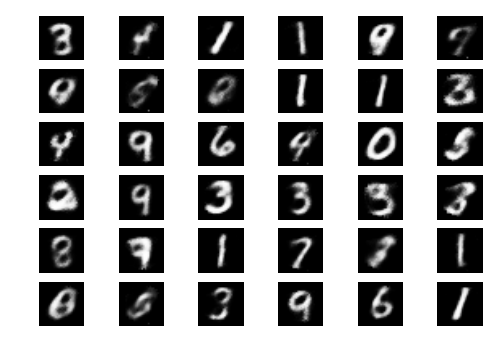

In [11]:
# Test for Discriminator (real image)
D_real_node  = C.combine([D_real.owner])
D_real_output = D_real_node.eval({X_real: images})
plot_images(D_real_output, subplot_shape=[6, 6])